In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# git repository directory
from pathlib import Path
git_dir = Path("/home/spott/code/pocket_replacement/")

# get 'environmental' variables:
import os, re

#check for 'export' lines.  This is *not* robust against lots of things, but it should work for this
export_re = re.compile(r"""^export ([^=]+)=(['\"])([^\2]*)\2;?$""")

with open(git_dir / ".env", 'r') as env_file:
    for line in env_file:
        m = export_re.match(line)
        if m:
            os.environ[m.group(1)] = m.group(3)
            
print(os.environ)

environ({'PATH': '/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin', 'LANG': 'en_US.UTF-8', 'USER': 'spott', 'HOME': '/home/spott', 'SHELL': '/bin/zsh', 'JPY_PARENT_PID': '7824', 'TERM': 'xterm-color', 'CLICOLOR': '1', 'PAGER': 'cat', 'GIT_PAGER': 'cat', 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline', 'POSTGRES_PASSWORD': 'ooCahc5ieth1aiNg', 'POSTGRES_DB': 'reddit_data'})


# Bookmark Recommendation Engine

I want to generate a recommendation engine for bookmarks.  Ideally, individual articles (I am going to stick with articles for this engine) will be assigned a set of topics, allowing for a recommendation for the next bookmark to read.

Getting the data for a page will involve:

* Scraper:  Takes an article and downloads to a database.  Ideally uses cookies so that we can do things like scrape the NYTimes.
* Parser: Given the source for an article (in the database), we get the "article" part (strip all the boilerplate).
* Tokenize: Given an "article", turn it into a bag of words -- perhaps with some 2 or 3 -grams as well.

Just using the bookmarks I have will make this more difficult:  I just don't have enough data (only 3-5k bookmarks/links).  However, using Hackernews and Reddit (and Big Query) will help drastically with this.  However, all of this is unlabeled data.  We would like to generate some labeled data, which is the tricky part.

## Developing a model:

Before we can start labeling *our* data, we need a "labeled" dataset.  Since Hackernews and Reddit have Big Query databases for them, we have *some* data that we can use:

### Reddit:

[Reddit's Big Query](https://bigquery.cloud.google.com/table/fh-bigquery:reddit_posts.full_corpus_201512) has a few columns:

* URL: we can scrape this in order to get the webpage content
* title: this might have information that allows us to get some topic data out.
* subreddit: this can be thought of as a "topic" for the article.  This isn't *always* useful (`/r/truereddit`, `/r/marijuanaenthusiasts`, `/r/longform`, etc. have topics that don't necessarily correlate with subreddit name), but should get us some information.
* comment threads: this could give us more text about a page in order to better guess the topic... maybe.

### Hackernews:

Hackernews' Big Query:

* URL
* title
* ID: this is the id of the post, from which we can get the full comment tree by looking at...
* parent: the parent of this post, which also has an ID, and has text.
* text: the text of the comment or "ask HN" thread.

Initially, I'm going to focus on using Reddit to generate a "labeled" dataset.  The "subreddit" gives us a nice topic, and the title can be used to maybe refine that (or make sure we are on the right track?)

## Big Query 'grab':

The first part is grabbing the relevant data from Big Query.  We don't want *all* the data.  Around 2015, [this grew to *200,000* posts per day!](http://jeroendelcour.nl/blog/An-annotated-history-of-Reddits-growth-in-daily-submissions?1), which is just far more than I can realistically deal with.

There are a few simiplifications we can start with:

* Only choose posts that got more than 1 upvote, and more than 10 comments.  These requirements are likely overlapping, but should significantly thin the number of posts.
* Remove common, very busy, non-text urls: `imgur` is an obvious one, `gfycat` is another.  We will need to do some analysis to see which URLs we should be removing.
* Look at a smaller date range.
* remove self posts

Use [this](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python) quickstart guide to install the `google-cloud-sdk` and `google-cloud-bigquery` libraries.

### Some exploratory analysis:

We first want to get a good list of domains to exclude.  The following sql will give the largest 10000 domains that are posted to reddit that aren't self-posts and have our vote and comment requirements:

```SQL
SELECT
  domain,
  COUNT(domain) AS count
FROM
  `fh-bigquery.reddit_posts.*`
WHERE
  (_TABLE_SUFFIX BETWEEN '2016_01' AND '2017_04' OR _TABLE_SUFFIX = 'full_corpus_201512')
  AND is_self = FALSE
  AND score > 1
  AND num_comments > 10
GROUP BY
  domain
ORDER BY
  count DESC
LIMIT
  10000
```

Which generates data that can be seen [here](https://docs.google.com/spreadsheets/d/1NPnIq8-LeSJq6b95c_DzuA62CzV4a_srwDp7Asr8p1g/edit?usp=sharing), with the first 20 values shown here:

In [2]:
import pandas as pd
url_df = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1NPnIq8-LeSJq6b95c_DzuA62CzV4a_srwDp7Asr8p1g' +
                   '/export?gid=22342664&format=csv',
                   # Set first column as rownames in data frame
                   index_col=0)
url_df.head(20)

,count
domain,
i.imgur.com,3925554
imgur.com,3854290
youtube.com,1353818
i.redd.it,591641
twitter.com,503207
i.reddituploads.com,356166
youtu.be,304224
gfycat.com,207913
reddit.com,172337


and a plot of the first 100 values.  This distribution has a pretty long tail, and a super-exponential falloff.

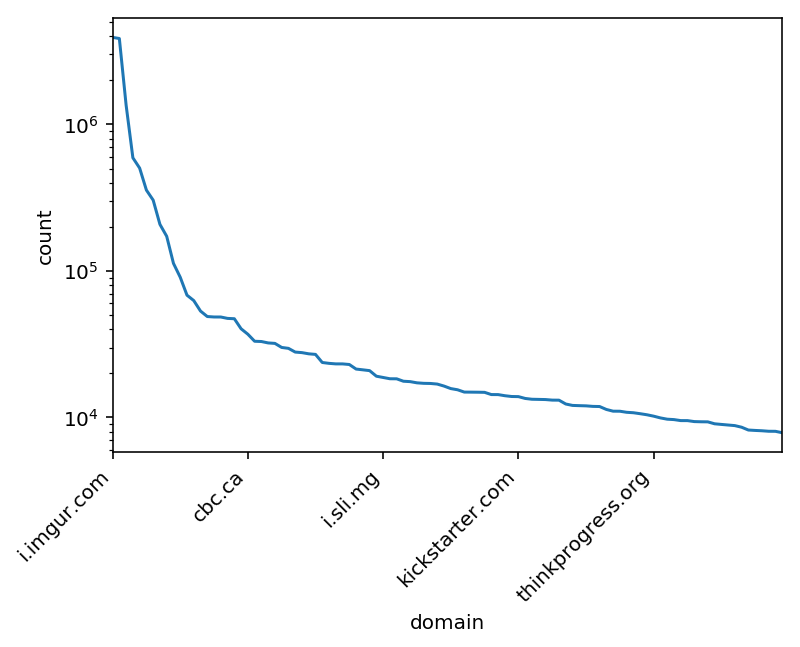

In [3]:
url_df[:100].plot(logy=True, legend=False);
plt.setp( plt.gca().xaxis.get_majorticklabels(), rotation=45, horizontalalignment="right");
plt.ylabel("count")

#### Filtering out urls by hand:

I really don't want some of these.  Some are images (`imgur.com`, `gfycat.com`, `qkme.me`, `i.minus.com` etc), video (`youtube.com`, `vimeo.com`, etc.), online stores (`amazon.com`, `store.steampowered.com`), or social media (`facebook.com`, `reddit.com`, etc.).  I will remove the following:

In [4]:
ignored_domains = list(set([
    "i.imgur.com","imgur.com","m.imgur.com","vimeo.com","youtube.com","twitter.com","youtu.be","reddit.com",
    "gfycat.com","en.wikipedia.com","qkme.me","quickmeme.com","livememe.com","flickr.com","facebook.com",
    "soundcloud.com","instagram.com","liveleak.com","i.minus.com","amazon.com","upload.wikimedia.org",
    "store.steampowered.com","kickstarter.com","twitch.tv","25.media.tumblr.com","m.youtube.com","streamable.com",
    "github.com","newegg.com","strawpoll.me","play.google.com","vine.co","vid.me","31.media.tumblr.com","ebay.com",
    "okcupid.com","vidble.com","giant.gfycat.com","38.media.tumblr.com","media.tumblr.com","reactiongifs.com",
    "movies.netflix.com","plus.google.com","i.qkme.me","i.reddituploads.com","i.redd.it","np.reddit.com","reddit.com",
    "livememe.com","streamable.com","euroshare.com","media.giphy.com","i.gyazo.com","vid.me","gyazo.com","us.battle.net"
    "imgflip.com","itunes.apple.com","en.m.wikipedia.com","bestbuy.com","giphy.com"
]));

This isn't perfect. I likely have some false negatives (various blog posts will be ignored even though I want those), and false positives (I probably missed some of the image sites).  But it should work well enough.

### Getting a subset of the data into a bigquery table we can use:

Then we will create a subset of the full reddit post dataset with the following restrictions (to start):

* post created after Jan 1, 2010 (UTC epoch time: 1262304000)
* score > 1
* comments > 10
* not a self post
* has a subreddit (subreddit != "null")
* not quarantined (unlikely to be spam?)
* not in `ignored_domains` list
* LIMIT 10,000,000 for the moment.

This results in the SQL query:

```SQL
SELECT created_utc, subreddit, domain, url, num_comments, score, ups, downs, title, permalink, gilded
  FROM `fh-bigquery.reddit_posts.*` WHERE 
  (_TABLE_SUFFIX BETWEEN '2016_01' AND '2017_04' OR _TABLE_SUFFIX = 'full_corpus_201512')
  AND created_utc > 1356998400 
  AND quarantine = FALSE
  AND is_self = FALSE 
  AND subreddit != "null" 
  AND num_comments > 10 
  AND score > 1
  AND domain NOT IN 'ignored_domains'
  LIMIT 10000000
```

where `'ignored_domains'` is the list from above.  This is easiest to do by generating the sql statement in python:

In [5]:
reduce_sql = f"""
SELECT created_utc, subreddit, domain, url, num_comments, score, ups, downs, title, permalink, gilded
  FROM `fh-bigquery.reddit_posts.*` WHERE 
  (_TABLE_SUFFIX BETWEEN '2016_01' AND '2017_04' OR _TABLE_SUFFIX = 'full_corpus_201512')
  AND created_utc > 1356998400 
  AND quarantine = FALSE
  AND is_self = FALSE 
  AND subreddit != "null" 
  AND num_comments > 10 
  AND score > 1
  AND domain NOT IN ({','.join("'" + x + "'" for x in ignored_domains)})
  LIMIT 10000000
"""
print(reduce_sql)


SELECT created_utc, subreddit, domain, url, num_comments, score, ups, downs, title, permalink, gilded
  FROM `fh-bigquery.reddit_posts.*` WHERE 
  (_TABLE_SUFFIX BETWEEN '2016_01' AND '2017_04' OR _TABLE_SUFFIX = 'full_corpus_201512')
  AND created_utc > 1356998400 
  AND quarantine = FALSE
  AND is_self = FALSE 
  AND subreddit != "null" 
  AND num_comments > 10 
  AND score > 1
  AND domain NOT IN ('play.google.com','qkme.me','flickr.com','newegg.com','reddit.com','streamable.com','movies.netflix.com','euroshare.com','gfycat.com','i.redd.it','i.minus.com','vidble.com','imgur.com','twitch.tv','ebay.com','en.wikipedia.com','gyazo.com','m.youtube.com','plus.google.com','store.steampowered.com','youtu.be','soundcloud.com','livememe.com','i.imgur.com','strawpoll.me','i.gyazo.com','giphy.com','okcupid.com','i.reddituploads.com','quickmeme.com','vine.co','en.m.wikipedia.com','media.giphy.com','38.media.tumblr.com','liveleak.com','vid.me','amazon.com','kickstarter.com','m.imgur.com','reacti

This created ~4.6 million rows and 1.35 GB of data.  Once you strip out all the image sites and self-posts, reddit gets a lot smaller.  This isn't really "big data", though we haven't even started downloading webpages yet.

We can play around with this data, getting individual rows as dicts (we wouldn't want to do this for more than a handful of rows though... far too much data duplication):

In [6]:
def get_table():
    #from google.cloud import bigquery
    from google.cloud.bigquery import Client as BQClient

    # Create a client, and get the table that we are interested in:
    bigquery_client = BQClient(project="pocketreplacement")
    dataset_name = 'RedditData'
    dataset = bigquery_client.dataset(dataset_name)
    table = dataset.table("subset")
    table.reload()
    return table

def get_schema(table):
    return tuple(x.name for x in table.schema)

def print_n_results(n=3):
    import pprint
    table = get_table()
    data_iter = table.fetch_data(max_results=n)
    schema = get_schema(table)

    pp = pprint.PrettyPrinter(indent=2)

    for row in data_iter:
        pp.pprint(dict(zip(schema,row)))
        
print_n_results()

{ 'created_utc': 1491262105,
  'domain': 'latimes.com',
  'downs': None,
  'gilded': 0,
  'num_comments': 89,
  'permalink': '/r/flying/comments/63ai5z/glad_to_hear_that_harrison_ford_wont_face/',
  'score': 98,
  'subreddit': 'flying',
  'title': "Glad to hear that Harrison Ford won't face disciplinary action for "
           "landing on a taxiway at John Wayne Airport. It's a big mistake, "
           "but face it, we've all made one.",
  'ups': None,
  'url': 'http://www.latimes.com/local/lanow/la-me-ln-ford-taxiway-agreement-20170331-story.html'}
{ 'created_utc': 1491323478,
  'domain': 'dallasnews.com',
  'downs': None,
  'gilded': 0,
  'num_comments': 83,
  'permalink': '/r/Dallas/comments/63f79d/frisco_homeowner_with_nosoliciting_sign_shoots/',
  'score': 125,
  'subreddit': 'Dallas',
  'title': 'Frisco homeowner with no-soliciting sign shoots door-to-door '
           'salesman, police say',
  'ups': None,
  'url': 'http://www.dallasnews.com/news/frisco/2017/04/03/man-arrested-

We can create a pandas dataframe from this, but unfortunately there doesn't appear to be a way to do this without first converting the interator to a list.  This likely won't scale very well.  We want to put this into a database of some kind so we can try and do interesting things with it.

In [7]:
table = get_table()
data_iter = list(table.fetch_data(max_results=100))
schema = tuple(x.name for x in table.schema)

reddit_df = pd.DataFrame(data_iter, columns=schema)
reddit_df.head(5)

,created_utc,subreddit,domain,url,num_comments,score,ups,downs,title,permalink,gilded
0,1491262105,flying,latimes.com,http://www.latimes.com/local/lanow/la-me-ln-fo...,89,98,None,None,Glad to hear that Harrison Ford won't face dis...,/r/flying/comments/63ai5z/glad_to_hear_that_ha...,0
1,1491323478,Dallas,dallasnews.com,http://www.dallasnews.com/news/frisco/2017/04/...,83,125,None,None,Frisco homeowner with no-soliciting sign shoot...,/r/Dallas/comments/63f79d/frisco_homeowner_wit...,0
2,1484621871,Portland,pps.net,http://www.pps.net/site/default.aspx?PageType=...,58,61,None,None,"PPS: Tuesday, January 17: All schools and offi...",/r/Portland/comments/5ofiej/pps_tuesday_januar...,0
3,1487100709,AdviceAnimals,imgflip.com,https://imgflip.com/i/1jn3pz#XidFB0YXOKL7HXIB.16,58,667,None,None,At least it happened before I bought her Valen...,/r/AdviceAnimals/comments/5u2f58/at_least_it_h...,0
4,1483812133,Smite,clips.twitch.tv,https://clips.twitch.tv/omegaqtz/KindGorillaSu...,183,223,None,None,Omega Roasting weak3n,/r/Smite/comments/5mlr45/omega_roasting_weak3n/,0


## Scraping pages:

The next step is to download the pages, along with the data from BigQuery to a local database where we can work with it.  This is done asynchronously, and not in a jupyter notebook (for obvious reasons), but I'll cover the basics of how pages are downloaded and inserted here.

The first thing to keep in mind is that we are going to try and download a few million URLs.  At 1 Meg a page (an overestimate for most pages... we are only interested in the text part of the page), that is roughly 5 TB!  This kind of data requires us to do a fair amount of the preprocessing up front:  We don't want to store more than we have to.

I also don't want to wait around for these pages to download before starting the next one, which demands an async tool.

I use `aiohttp` for async HTTP "getter", and `newspaper` as an "article extractor".  We will store this into a database using `asyncpg`.

An example of getting a webpage using `aiohttp`  (from the docs).  This will be done for each page:

In [8]:
import aiohttp
import asyncio
import async_timeout

async def fetch(session, url):
    with async_timeout.timeout(10):
        async with session.get(url) as response:
            return await response.text()

async def main():
    async with aiohttp.ClientSession() as session:
        html = await fetch(session, 'http://python.org')
        print(html[:1000] + "[...]")

loop = asyncio.get_event_loop()
loop.run_until_complete(main())

<!doctype html>
<!--[if lt IE 7]>   <html class="no-js ie6 lt-ie7 lt-ie8 lt-ie9">   <![endif]-->
<!--[if IE 7]>      <html class="no-js ie7 lt-ie8 lt-ie9">          <![endif]-->
<!--[if IE 8]>      <html class="no-js ie8 lt-ie9">                 <![endif]-->
<!--[if gt IE 8]><!--><html class="no-js" lang="en" dir="ltr">  <!--<![endif]-->

<head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <link rel="prefetch" href="//ajax.googleapis.com/ajax/libs/jquery/1.8.2/jquery.min.js">

    <meta name="application-name" content="Python.org">
    <meta name="msapplication-tooltip" content="The official home of the Python Programming Language">
    <meta name="apple-mobile-web-app-title" content="Python.org">
    <meta name="apple-mobile-web-app-capable" content="yes">
    <meta name="apple-mobile-web-app-status-bar-style" content="black">

    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta name="HandheldFriendly" conte

### Database itself:

I'm using docker for the database, in order to introduce myself to this tool.  I'm using the `docker-py` package, so I can create and run the docker containers from python, and the [`local-persist`](https://github.com/CWSpear/local-persist#benefits) volume driver to keep the database persistant and movable.

First get the location of this notebook.  We will put the data in a local data directory.

In [9]:
import docker

client = docker.from_env()
data_dir = git_dir / "data" / "data"

generate a password for the database (possibly using something like:
```
export POSTGRES_PASSWORD='`pwgen 16 1`'
```
) and retrieve it into a variable

In [10]:
import os
pg_password = os.environ['POSTGRES_PASSWORD']
pg_database = os.environ['POSTGRES_DB']

In [11]:
print(pg_password, pg_database)

ooCahc5ieth1aiNg reddit_data


Get the database volume if it exists, else create it:

In [12]:
try:
    database_loc = client.volumes.get("database_loc")
except docker.errors.APIError as e1:
    print("probably couldn't find volume 'database_loc', attempting to create it:")
    try:
        database_loc = client.volumes.create(name="database_loc",
                                             driver="local-persist",
                                             driver_opts={"mountpoint":data_dir.as_posix()})
    except docker.errors.APIError as e1:
        print("Couldn't obtain or create the volume.  Maybe docker is misconfigured?")
        print(f"exception from get: {e1}")
        print(f"exception from create: {e2}")

Get the database container if it exists, else create it.  Note that this is not ideal because the Postgres container is facing the world.  Ideally we would link the Postgres container with a container running the python scraper, so that the attack surface is constrained.  This isn't going into anything resembling production though, so we won't worry about that now.

In [13]:
try:
    db = client.containers.get("db")
except docker.errors.APIError as e1:
    print("probably couldn't find container 'db', attempting to create it:")
    try:
        db = client.containers.create("postgres",
                                       detach=True,
                                       name="db",
                                       environment={"POSTGRES_PASSWORD":pg_password, 
                                                    "POSTGRES_DB":pg_database},
                                       volumes={database_loc.name: 
                                                {'bind': '/var/lib/postgresql/data',
                                                 'mode': 'rw'}},
                                       
                                       ports={"5432/tcp": 5432}
                                      )
    except docker.errors.APIError as e2:
        print("Couldn't obtain or create the volume.  Maybe docker is misconfigured?")
        print(f"exception from get: {e1}")
        print(f"exception from create: {e2}")

Finally start the container if it needs to be started"

In [14]:
import time

db.reload()

if db.status != "running":
    db.start()
    time.sleep(1) # wait for a second and check again
    if db.status != "running":
        print("container started and then stopped again...")
else:
    print("container is running")

container is running


### Database schema

We also need a database schema for our data.  We will add a `html` and a `article` field for each `url`, which we will break out into a separate table in order to protect from reposts.  We will also break out the `domain` and `subreddit` fields into seperate tables and reference them as well.  So we will create our database as:

```SQL

CREATE DATABASE reddit_data;

CREATE TABLE subreddits (
  subreddit serial PRIMARY KEY,
  name text NOT NULL UNIQUE
);

CREATE TABLE domains (
  domain serial PRIMARY KEY,
  name text NOT NULL UNIQUE
);

-- This saves us from reposts.  A repost will not take up (too much) more space, but we will still get
-- more information (from more subreddits)
CREATE TABLE urls (
  url serial PRIMARY KEY,
  name text NOT NULL UNIQUE,
  domain integer NOT NULL REFERENCES domains (domain),    -- this is a key into the domains table
  html bytea NOT NULL,                           -- we want bytes for this to handle different encodings well.
  article text NOT NULL                          -- we want text for this.  We will convert the article text to UTF8
);

CREATE TABLE post (
  id char(6),                                          -- extracted from the permalink
  created timestamp NOT NULL,                          -- converted from the UTC date in epoch time
  subreddit integer NOT NULL REFERENCES subreddits (subreddit), -- this is a key into the subreddit table
  url integer NOT NULL REFERENCES urls (url),                    -- a key into the url table
  num_comments int,
  score int,        
  ups int,
  downs int,
  title text,
  permalink text,
  gilded int,
  PRIMARY KEY (id, subreddit)-- our primary key is a combination of the subreddit and the id
);
```

The database has been added already (the environment variable 'POSTGRES_DB' did that for us), we just need to create the tables.

In [15]:
import asyncio
import asyncpg


async def create_tables():
    conn = await asyncpg.connect(user="postgres",password=pg_password, database=pg_database,host="127.0.0.1")
    
    print("creating table 'subreddits'")
    try:
        await conn.execute('''
            CREATE TABLE subreddits (
              subreddit serial PRIMARY KEY,
              name text NOT NULL UNIQUE
            )
        ''')
    except asyncpg.DuplicateTableError as e: 
        print(e)
    
    print("creating table 'domains'")
    try:
        await conn.execute('''
            CREATE TABLE domains (
              domain serial PRIMARY KEY,
              name text NOT NULL UNIQUE
            )
        ''')
    except asyncpg.DuplicateTableError as e: 
        print(e)
    
    print("creating table 'urls'")
    try:
        await conn.execute('''
            CREATE TABLE urls (
              url serial PRIMARY KEY,
              name text UNIQUE,
              domain integer NOT NULL REFERENCES domains (domain),
              html bytea NOT NULL,
              article text NOT NULL
            )
        ''')
    except asyncpg.DuplicateTableError as e: 
        print(e)
    
    print("creating table 'posts'")
    try:
        await conn.execute('''
            CREATE TABLE posts (
              id char(6),                                         
              created timestamp NOT NULL,                         
              subreddit integer NOT NULL REFERENCES subreddits (subreddit), 
              url integer NOT NULL REFERENCES urls (url),
              num_comments int,
              score int,        
              ups int,
              downs int,
              title text,
              permalink text,
              gilded int,
              PRIMARY KEY (id, subreddit)
            );
        ''')
    except asyncpg.DuplicateTableError as e:
        print(e)
    
    await conn.close()


In [16]:
asyncio.get_event_loop().run_until_complete(create_tables())

creating table 'subreddits'
relation "subreddits" already exists
creating table 'domains'
relation "domains" already exists
creating table 'urls'
relation "urls" already exists
creating table 'posts'
relation "posts" already exists


### Retrieving and parsing a url:

In [17]:
async def parse_html(url,html):
    import newspaper
    
    ar = newspaper.Article(url, keep_article_html=True)
    ar.download(input_html=html)
    ar.parse()
    return ar.article_html

async def get_raw_html(url):
    async with aiohttp.ClientSession() as session:
        return await fetch(session, url)
        
async def get_parsed_html(url):
    return await parse_html(url, await get_raw_html(url))


asyncio.get_event_loop().run_until_complete(get_parsed_html("https://newspaper.readthedocs.io/en/latest/user_guide/advanced.html#keeping-html-of-main-body-article"))

'<div><p id="id1"></p> \n<p>This section of the docs shows how to do some useful but advanced things\nwith newspaper.</p>\n<h2>Multi-threading article downloads<a class="headerlink" href="#multi-threading-article-downloads" title="Permalink to this headline">&#182;</a></h2>\n<p><strong>Downloading articles one at a time is slow.</strong> But spamming a single news source\nlike cnn.com with tons of threads or with ASYNC-IO will cause rate limiting\nand also doing that is very mean.</p>\n<p>We solve this problem by allocating 1-2 threads per news source to both greatly\nspeed up the download time while being respectful.</p>\n<pre><p></p><p class="gp">&gt;&gt;&gt; </p><p class="kn">import</p> <p class="nn">newspaper</p>\n<p class="gp">&gt;&gt;&gt; </p><p class="kn">from</p> <p class="nn">newspaper</p> <p class="kn">import</p> <p class="n">news_pool</p>\n\n<p class="gp">&gt;&gt;&gt; </p><p class="n">slate_paper</p> <p class="o">=</p> <p class="n">newspaper</p><p class="o">.</p><p class="n"

#### Writing to database:

In [18]:
async def write_post_to_db(connection, id, created, subreddit, 
                           url, num_comments, score, ups, 
                           downs, title, permalink, gilded, domain, html, article):
    # insert into 'url', unless it exists.  
    # We try to add the URL first because this is likely to be new and unique, 
    # and the exception path should be nominally short:
    which_not_null_regex = re.compile('^null value in column "([^"]+)"')
    try:
        await connection.execute('''
            INSERT INTO "urls" (name, domain, html, article) VALUES \
                ($1, (SELECT domain FROM domains WHERE name = $2), $3, $4) 
        ''', url, domain, html, article)
    except asyncpg.UniqueViolationError as unique:
        # we already have this url, so we pass
        pass
        
    except asyncpg.NotNullViolationError as not_null:
        m = which_not_null_regex.match(str(not_null))
        if m.group(1) == "domain":
            await connection.execute('''INSERT INTO "domains" (name) VALUES ($1)''', domain)
            await connection.execute('''
                INSERT INTO "urls" (name, domain, html, article) VALUES \
                    ($1, (SELECT domain FROM domains WHERE name = $2), $3, $4) 
            ''', url, domain, html, article)
        else:
            raise not_null

    try:
        await connection.execute('''
            INSERT INTO "posts" (id, created, subreddit, url, num_comments, score, ups, downs, title, permalink, gilded) VALUES \
                ($1, $2, (SELECT subreddit FROM subreddits WHERE name=$3), (SELECT url FROM urls WHERE name=$4), $5, $6, $7, $8, $9, $10, $11)
            ''', id, created, subreddit, url, num_comments, score, ups, downs, title, permalink, gilded)
    except asyncpg.NotNullViolationError as not_null:
        m = which_not_null_regex.match(str(not_null))
        if m.group(1) == "subreddit":
            await connection.execute('''INSERT INTO "subreddits" (name) VALUES ($1)''', subreddit)
            await connection.execute('''
            INSERT INTO "posts" (id, created, subreddit, url, num_comments, score, ups, downs, title, permalink, gilded) VALUES \
                ($1, $2, (SELECT subreddit FROM subreddits WHERE name=$3), (SELECT url FROM urls WHERE name=$4), $5, $6, $7, $8, $9, $10, $11)
            ''', id, created, subreddit, url, num_comments, score, ups, downs, title, permalink, gilded)
        else:
            raise not_null
    
    
    
async def test_write_post_to_db():
    from datetime import datetime
    conn = await asyncpg.connect(user="postgres",password=pg_password, database=pg_database,host="127.0.0.1")
    await write_post_to_db(conn, "aaaa", datetime.utcfromtimestamp(1491262105), "nfl", "http://espn.com/blahbloo/hello.html",10,10,11,1,
                     "espn","aaaa/blah/blah",None,"espn.com",b"<html>some html stuff<\html>","some html stuff")


This allows us to add a post, including adding the URL, subreddit and domain if they don't exist, and will throw an error if the post exists.

In [19]:
import ty

ModuleNotFoundError: No module named 'ty'

In [ ]:
type(datetime)

In [ ]:
from typing import NamedTuple, Type

class Post(NamedTuple):
    id: str
    created: Type[datetime]
    subreddit: str
    domain: str
    url: str
    num_comments: int
    score: int
    ups: int
    downs: int
    title: str
    permalink: str
    gilded: int

def pre_processing(created, subreddit, domain, url, num_comments, score, ups,
                   downs, title, permalink, gilded):
    created = datetime.utcfromtimestamp(created)
    id = permalink.split("/")[4]
    return Post(id, created, subreddit, domain, url, num_comments, score, ups,
                downs, title, permalink, gilded)


In [ ]:
from collections import namedtuple
from datetime import datetime

table = get_table()
data_iter = table.fetch_data(max_results=10)
#Post = namedtuple("Post", [ x.name for x in table.schema ])

for item in data_iter:
    print(item)
    p = pre_processing(*item)
    print(p)
    print("======")
#    p.created_utc = datetime.utcfromtimestamp(p.created_utc)
#    print(p)

In [ ]:
t